In [1]:
import json
import pandas as pd
import numpy as np
import re

In [2]:
fileDir = "resources/"
wikiMoviesRaw = []
with open(f'{fileDir}wikipedia-movies.json', mode='r') as file:
    wikiMoviesRaw = json.load(file)


In [3]:
kaggleMetadata = pd.read_csv(f'{fileDir}movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{fileDir}ratings.csv')

In [4]:
wikiMoviesDF = pd.DataFrame(wikiMoviesRaw)

In [5]:
wiki_movies = [movie for movie in wikiMoviesRaw if ('Director' in movie or 'Directed by' in movie)
    and 'imdb_link' in movie
    and 'No. of episodes' not in movie]
len(wiki_movies)

7076

In [6]:
def clean_movie(movie):
    movie = dict(movie)
    altTitles = {}
    for key in ['Arabic', 'Cantonese', 'Chinese', 'French', 'Hangul', 'Hebrew', 'Hepburn', 'Japanese', 'Literally',  'Mandarin', 'McCune-Reischauer', 'Original title', 'Polish',  'Revised Romanization', 'Romanized', 'Russian', 'Simplified', 'Traditional', 'Yiddish']:
        if key in movie:
            altTitles[key] = movie[key]
            movie.pop(key)
    if len(altTitles) > 0:
        movie['alternate_titles'] = altTitles
        # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')
    return movie

In [7]:
cleanMovie = [clean_movie(movie) for movie in wiki_movies]
wikiMoviesDF = pd.DataFrame(cleanMovie)

In [8]:
wikiMoviesDF['imdb_id'] = wikiMoviesDF['imdb_link'].str.extract(r'(tt\d{7})')


In [9]:
wikiMoviesDF.drop_duplicates(subset='imdb_id', inplace=True)


In [10]:
wiki_columns_to_keep = [column for column in wikiMoviesDF.columns if wikiMoviesDF[column].isnull().sum() < len(wikiMoviesDF) * 0.9]
wikiMoviesDF = wikiMoviesDF[wiki_columns_to_keep]


In [11]:
boxOffice = wikiMoviesDF["Box office"].dropna()

In [12]:
#def isNotAString(x):
#    return type(x) != str
boxOffice[boxOffice.map(lambda x: type(x) != str)]


34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [13]:
formOne = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
formOneMatches = boxOffice.str.contains(formOne, flags=re.IGNORECASE, na=False)
formOneMatches.sum()

3828

In [14]:
formTwo = r'\$\s*\d{1,3}(?:[,\.]\d{3})+'
formTwoMatches = boxOffice.str.contains(formTwo, flags=re.IGNORECASE, na=False)
formTwoMatches.sum()

1528

In [15]:
boxOffice[( ~formOneMatches) & (~formTwoMatches)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
110                        $4.35-4.37 million
126                [US$1,531,489, (domestic)]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 159, dtype: object

In [16]:
boxOffice = boxOffice.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)


In [17]:
boxOffice.str.extract(f'({formOne}|{formTwo})')

,0
0,$21.4 million
1,$2.7 million
2,"$57,718,089"
3,"$7,331,647"
4,"$6,939,946"
...,...
7070,$19.4 million
7071,$41.9 million
7072,$76.1 million
7073,$38.4 million


In [18]:
def parseDollars(string):
    if type(string) != str:
        return np.NaN
    # $###.# million and billion
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', string, flags=re.IGNORECASE):
        return float(re.sub('\$|\s|[a-zA-Z]','',string)) * 1000000
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', string, flags=re.IGNORECASE):
        return float(re.sub('\$|\s|[a-zA-Z]','',string)) * 1000000000
    #  $###,###,###.##
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', string, flags=re.IGNORECASE):
        return float(re.sub('\$|,','',string))
    else:
        return np.nan


In [19]:
wikiMoviesDF['boxOffice'] = boxOffice.str.extract(f'({formOne}|{formTwo})', flags=re.IGNORECASE)[0].apply(parseDollars)

In [20]:
wikiMoviesDF.drop('Box office', axis=1, inplace=True)

In [21]:
budget = wikiMoviesDF['Budget'].dropna()
budget = budget.map(lambda x: ' '.join(x) if type(x)==list else x)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [22]:
matchesFormOne = budget.str.contains(formOne, flags=re.IGNORECASE, na=False)
matchesFormTwo = budget.str.contains(formTwo, flags=re.IGNORECASE, na=False)
len(budget[~matchesFormOne & ~matchesFormTwo])

38

In [23]:
budget = budget.str.replace(r'\[\d+\]\s*','', regex=True)

budget[~matchesFormOne & ~matchesFormTwo]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973                     $34 million
1126                   $120 million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360                   $150 million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034                  $$200 million
5055                   $155 million
5419                    $40 

In [24]:
#wikiMoviesDF['budget']=budget.str.extract(f'({formOne}|{formTwo})', flags=re.IGNORECASE)[0]

In [25]:
wikiMoviesDF['budget'] = budget.str.extract(f'({formOne}|{formTwo})', flags=re.IGNORECASE)
wikiMoviesDF.drop("Budget", axis=1, inplace=True)

In [26]:
releaseDate = wikiMoviesDF["Release date"].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
releaseDate

0                            July 11, 1990 ( 1990-07-11 )
1       May 17, 1990 ( 1990-05-17 ) (Cannes Film Marke...
2                          August 10, 1990 ( 1990-08-10 )
3                        December 25, 1990 ( 1990-12-25 )
4                                       December 19, 1990
                              ...                        
7071     December 25, 2018 ( 2018-12-25 ) (United States)
7072    December 11, 2018 ( 2018-12-11 ) ( Samuel Gold...
7073    November 8, 2018 ( 2018-11-08 ) ( AFI Fest ) D...
7074    August 31, 2018 ( 2018-08-31 ) ( Telluride ) D...
7075                      28 December 2018 ( 2018-12-28 )
Name: Release date, Length: 7001, dtype: object

In [27]:
# forms to parse:
# 1) full month name + (one or two digit days) + possible comma + four digit year i.e. December 25, 2022
# 2) four digit year + two digit month + two digit day + a symbol seperator i.e. (2022/12/25)
# 3) full month name + four digit year i.e. December 2022
# 4) four digit year i.e. 2022
'''
dateFormOne = re.compile(r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}', flags=re.IGNORECASE)
dateFormTwo = re.compile(r'\d{4}.[01]\d.[0123]\d', flags=re.IGNORECASE)
dateFormThree = re.compile(r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}', flags=re.IGNORECASE)
dateFormFour = re.compile(r'\d{4}', flags=re.IGNORECASE)

temp = "December 25, 2022"
temp2 = "2022/12/25"
temp3 = "December 2022"
temp4 = "2022"
tempList = [temp, temp2, temp3, temp4]
def checkForm(strlist):
    results = []
    for item in strlist:
        if dateFormOne.match(item):
            results.append((item, dateFormOne.match(item)))
        elif dateFormTwo.match(item):
            results.append((item, dateFormTwo.match(item)))
        elif dateFormTwo.match(item):
            results.append((item, dateFormThree.match(item)))
        elif dateFormTwo.match(item):
            results.append((item, dateFormFour.match(item)))
    return results
print(checkForm(tempList))
'''
dateFormOne = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
dateFormTwo = r'\d{4}.[01]\d.[0123]\d'
dateFormThree = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
dateFormFour = r'\d{4}'
wikiMoviesDF['releaseDate'] = pd.to_datetime(releaseDate.str.extract(f'({dateFormOne}|{dateFormTwo}|{dateFormThree}|{dateFormFour})', flags=re.IGNORECASE)[0], infer_datetime_format=True)
wikiMoviesDF['releaseDate']

0      1990-07-11
1      1990-05-17
2      1990-08-10
3      1990-12-25
4      1990-12-19
          ...    
7071   2018-12-25
7072   2018-12-11
7073   2018-11-08
7074   2018-08-31
7075   2018-12-01
Name: releaseDate, Length: 7033, dtype: datetime64[ns]

In [28]:
runningTime = wikiMoviesDF['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
runningTime.str.contains(r'^\d*\s*[mM]inutes$', flags=re.IGNORECASE, na=False).sum()

6528

In [29]:
runningTime[runningTime.str.contains(r'^\d*\s*[mM]inutes$', flags=re.IGNORECASE, na=False) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [30]:
runningTime.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False).sum()

6877

In [32]:
runningTime[runningTime.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False) != True]

668                     UK:84 min (DVD version) US:86 min
727                         78-102 min (depending on cut)
840                       Varies (79 [3] –84 [1] minutes)
1347                                              25 : 03
1443    United States: 77 minutes Argentina: 94 minute...
1499                                            1hr 35min
1551                                               varies
1774                    Netherlands:96 min, Canada:95 min
1777                                       approx. 14 min
2273                                           1 h 43 min
2993                                               1h 48m
3925                                              4 hours
4425    US domestic version: 86 minutes Original versi...
4967    Theatrical cut: 97 minutes Unrated cut: 107 mi...
5424                    115 [1] /123 [2] /128 [3] minutes
5447                                    1 hour 32 minutes
7075                Variable; 90 minutes for default path
Name: Running 

In [72]:
runningTimeExtract = runningTime.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
runningTimeExtract = runningTimeExtract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
runningTimeExtract.sample(n=10)

,0,1,2
5418,0.0,0.0,90.0
5885,0.0,0.0,125.0
5180,0.0,0.0,108.0
1639,0.0,0.0,120.0
5365,0.0,0.0,108.0
4406,0.0,0.0,82.0
5042,0.0,0.0,108.0
435,0.0,0.0,91.0
20,0.0,0.0,85.0
5317,0.0,0.0,99.0


In [77]:
wikiMoviesDF['runningTime'] = runningTimeExtract.apply(lambda row: row[0]*60 + row[1] if row[2]==0 else row[2], axis=1)
wikiMoviesDF.drop('Running time', axis=1, inplace=True)

KeyError: "['Running time'] not found in axis"

In [84]:
kaggleMetadata['adult'].value_counts()
kaggleMetadata[~kaggleMetadata['adult'].isin(['True', 'False'])]

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [86]:
kaggleMetadata = kaggleMetadata[kaggleMetadata['adult'] == 'False'].drop('adult', axis='columns')
kaggleMetadata

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [88]:
kaggleMetadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [90]:
kaggleMetadata['video'] = kaggleMetadata['video'] == 'True'

In [91]:
kaggleMetadata['budget'] = kaggleMetadata['budget'].astype(int)
kaggleMetadata['id'] = pd.to_numeric(kaggleMetadata['id'], errors='raise')
kaggleMetadata['popularity'] = pd.to_numeric(kaggleMetadata['popularity'], errors='raise')

In [94]:
kaggleMetadata['release_date'] = pd.to_datetime(kaggleMetadata['release_date'], errors='raise')

In [97]:
ratings.info(null_counts=True)
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

<ipython-input-97-2c5da9f6eedf>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  ratings.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

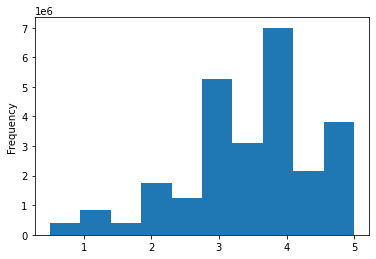

In [101]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()